# International Hedging Cost

In [1]:
import os
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt

# Path Management

In [77]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")
hc_path = os.path.join(data_path, "fx_hc.parquet")
yields_path = os.path.join(data_path, "yields.parquet")

# Read in and collect data

In [87]:
df_hc = (pd.read_parquet(
    path = hc_path, engine = "pyarrow").
    dropna().
    drop(columns = ["field"]).
    assign(ticker = lambda x: x.ticker.str.split(" ").str[0]))

df_yield = (pd.read_parquet(
    path = yields_path, engine = "pyarrow").
    drop(columns = ["field"]).
    dropna().
    assign(ticker = lambda x: x.ticker.str.split(" ").str[0]))

In [90]:
df_country = pd.DataFrame({
    "name": ["E", "J"],
    "country": ["Euro", "Jap"]})

df_name = (df_hc.assign(
    name = lambda x: x.ticker.str.split("FXHCU").str[1].str[0].str.strip()).
    dropna().
    merge(right = df_country, how = "inner", on = ["name"]).
    drop(columns = ["name"]))

In [98]:
sov_yield = ["GECU10YR", "GJGB10"]
df_sov = pd.concat([df_yield, (df_hc.query("ticker == @sov_yield"))])

# Comparing Yields

In [115]:
df_renamer = pd.DataFrame({
    "name": ["GU", "US", "GE", "GJ"],
    "country": ["UK", "US", "Euro", "Japanese"]})

df_sov_name = (df_sov.assign(
    name = lambda x: x.ticker.str[0:2]).
    merge(right = df_renamer, how = "inner", on = ["name"]).
    drop(columns = ["name"]))

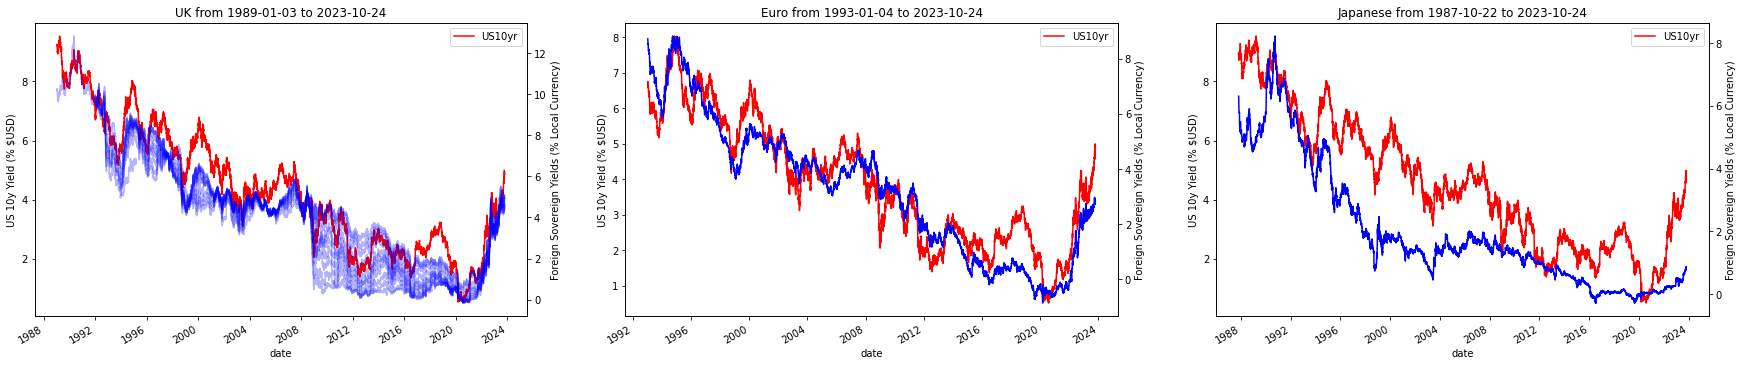

In [167]:
sov_countries = df_sov_name.query("country != 'US'").country.drop_duplicates().to_list()
fig, axes = plt.subplots(ncols = len(sov_countries), figsize = (30,6))

for i, country in enumerate(sov_countries):
    
    df_sov_tmp = (df_sov_name.query(
        "country == @country").
        drop(columns = ["country"]).
        pivot(index = "date", columns = "ticker", values = "value").
        reset_index())
    
    df_us = (df_sov_name.query(
        "country == 'US'").
        drop(columns = ["country", "ticker"]).
        rename(columns = {"value": "US10yr"}).
        reset_index())
    
    df_combined = (df_sov_tmp.merge(right = df_us, how = "inner", on = ["date"]).set_index("date"))
    
    (df_combined[
        ["US10yr"]].
        plot(
            ax = axes[i],
            color = "r",
            ylabel = "US 10y Yield (% $USD)"))
    
    twinx = axes[i].twinx()
    
    if len(df_sov_tmp.columns.to_list()) > 2: alpha = 0.3
    else: alpha = 1
    
    (df_combined.drop(
        columns = ["index", "US10yr"]).
        plot(
            ax = twinx,
            color = "blue",
            alpha = alpha,
            legend = False,
            ylabel = "Foreign Sovereign Yields (% Local Currency)",
            title = "{} from {} to {}".format(
                country,
                df_combined.index.min().date(),
                df_combined.index.max().date())))

# Hedge Costs

We are going to compare the hedge costs of sovereign yields compared against their domestic sovereign 10yr and the unhedged 10yr

In [183]:
# it will take df_name which we've defined before
def _calc_hc(df: pd.DataFrame, df_name: pd.DataFrame) -> pd.DataFrame:
    display(df)
    display(df_name)

(df_sov_name.query(
    "country != 'US'").
    query("ticker == ['GUKG1', 'GUKG10']").
    groupby("ticker").
    apply(_calc_hc, df_name))

,date,ticker,value,country
16416,1994-01-04,GUKG1,5.091,UK
16417,1994-01-05,GUKG1,5.123,UK
16418,1994-01-06,GUKG1,5.114,UK
16419,1994-01-07,GUKG1,5.088,UK
16420,1994-01-10,GUKG1,5.100,UK
...,...,...,...,...
23905,2023-10-18,GUKG1,5.061,UK
23906,2023-10-19,GUKG1,5.023,UK
23907,2023-10-20,GUKG1,4.937,UK
23908,2023-10-23,GUKG1,4.894,UK


,date,ticker,value,country
0,2007-02-01,FXHCUE12,1.2764,Euro
1,2007-02-02,FXHCUE12,1.2922,Euro
2,2007-02-05,FXHCUE12,1.2920,Euro
3,2007-02-06,FXHCUE12,1.2758,Euro
4,2007-02-07,FXHCUE12,1.2694,Euro
...,...,...,...,...
54434,2023-10-18,FXHCUJ18,5.3112,Jap
54435,2023-10-19,FXHCUJ18,5.3214,Jap
54436,2023-10-20,FXHCUJ18,5.2673,Jap
54437,2023-10-23,FXHCUJ18,5.2427,Jap


,date,ticker,value,country
63446,1989-01-02,GUKG10,10.190,UK
63447,1989-01-03,GUKG10,10.230,UK
63448,1989-01-04,GUKG10,10.230,UK
63449,1989-01-05,GUKG10,10.270,UK
63450,1989-01-06,GUKG10,10.270,UK
...,...,...,...,...
72477,2023-10-18,GUKG10,4.657,UK
72478,2023-10-19,GUKG10,4.673,UK
72479,2023-10-20,GUKG10,4.651,UK
72480,2023-10-23,GUKG10,4.599,UK


,date,ticker,value,country
0,2007-02-01,FXHCUE12,1.2764,Euro
1,2007-02-02,FXHCUE12,1.2922,Euro
2,2007-02-05,FXHCUE12,1.2920,Euro
3,2007-02-06,FXHCUE12,1.2758,Euro
4,2007-02-07,FXHCUE12,1.2694,Euro
...,...,...,...,...
54434,2023-10-18,FXHCUJ18,5.3112,Jap
54435,2023-10-19,FXHCUJ18,5.3214,Jap
54436,2023-10-20,FXHCUJ18,5.2673,Jap
54437,2023-10-23,FXHCUJ18,5.2427,Jap


""
